In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/idankorach/Repositories/InvestmentPredictor/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/idankorach/Repositories/InvestmentPredictor/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/idankorach/Repositories/InvestmentPredictor/.venv/lib/python3.12/

In [2]:
def load_financial_data(years=range(2014, 2019)):
    """
    Load financial data for specified years and return a dictionary of dataframes
    and the combined dataframe.
    """
    
    # Set style for better visualizations
    plt.style.use('ggplot')
    sns.set_palette("husl")

    # Configure pandas display options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # Define the base path relative to the notebook
    base_path = Path('..') / 'data' / 'external' / 'archive (3)'
    data_frames = {}
    
    for year in years:
        file_path = base_path / f'{year}_Financial_Data.csv'
        try:
            # Load data for each year
            df = pd.read_csv(file_path)
            # Add year column
            df['Year'] = year
            data_frames[year] = df
            print(f"Successfully loaded data for {year}: {df.shape[0]} rows and {df.shape[1]} columns")
        except FileNotFoundError:
            print(f"Warning: File not found: {file_path}")
    
    if not data_frames:
        raise ValueError("No data files were successfully loaded. Please check the file paths.")
        
    # Combine all dataframes
    combined_df = pd.concat(data_frames.values(), axis=0, ignore_index=True)
    print(f"\nTotal combined dataset: {combined_df.shape[0]} rows and {combined_df.shape[1]} columns")
    
    return data_frames, combined_df

def analyze_data_quality(df):
    """
    Analyze the quality of the data including missing values,
    data types, and basic statistics.
    """
    print("\n=== Data Quality Analysis ===")
    
    # Display info about data types and non-null counts
    print("\nData Types and Non-Null Counts:")
    print(df.info())
    
    # Analyze missing values
    missing_values = df.isnull().sum()
    missing_percentages = (missing_values / len(df)) * 100
    
    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage Missing': missing_percentages
    })
    
    print("\nColumns with missing values:")
    print(missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Values', ascending=False))
    
    return missing_info

def plot_data_distribution(df):
    """
    Create visualizations for understanding data distribution
    """
    # Create figure for sector distribution
    plt.figure(figsize=(15, 6))
    sns.countplot(data=df, y='Sector', order=df['Sector'].value_counts().index)
    plt.title('Distribution of Companies Across Sectors')
    plt.xlabel('Number of Companies')
    plt.tight_layout()
    plt.show()
    
    # Create figure for class distribution by year
    plt.figure(figsize=(10, 6))
    class_by_year = df.groupby('Year')['Class'].value_counts(normalize=True).unstack()
    class_by_year.plot(kind='bar', stacked=True)
    plt.title('Distribution of Classes by Year')
    plt.xlabel('Year')
    plt.ylabel('Proportion')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()
    
def analyze_key_metrics(df):
    """
    Analyze and visualize key financial metrics
    """
    # Select important financial metrics using correct column names from the data
    key_metrics = [
        'Revenue Growth',
        'operatingProfitMargin',
        'returnOnEquity',
        'currentRatio'
    ]
    
    # Create box plots for key metrics by year
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(key_metrics):
        sns.boxplot(data=df, x='Year', y=metric, ax=axes[idx])
        axes[idx].set_title(f'{metric} Distribution by Year')
        axes[idx].tick_params(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create correlation heatmap for key metrics
    correlation_metrics = key_metrics + ['Class']
    correlation = df[correlation_metrics].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Key Financial Metrics')
    plt.tight_layout()
    plt.show()

# We could add more detailed analysis metrics like these:
additional_metrics = [
    'Gross Margin',
    'Net Profit Margin',
    'ROE',
    'Debt to Equity',
    'EPS Growth',
    'Free Cash Flow growth'
]

def analyze_financial_ratios(df):
    """
    Analyze important financial ratios and their relationship with the target variable
    """
    # Important financial ratios using the correct column names from your data
    ratios = [
        'debtEquityRatio',         # instead of 'Debt to Equity'
        'returnOnEquity',          # instead of 'ROE'
        'operatingProfitMargin',   # instead of 'Operating Margin'
        'netProfitMargin'          # instead of 'Net Profit Margin'
    ]
    
    # Verify ratios exist in dataframe
    available_ratios = [ratio for ratio in ratios if ratio in df.columns]
    if not available_ratios:
        print("Warning: None of the specified ratios found in the dataframe")
        return
    
    # Create violin plots for each ratio by class
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, ratio in enumerate(available_ratios):
        sns.violinplot(data=df, x='Class', y=ratio, ax=axes[idx])
        axes[idx].set_title(f'{ratio} Distribution by Class')
    
    plt.tight_layout()
    plt.show()

In [3]:
def preprocess_data(df):
    """
    Preprocess the financial data including:
    1. Remove unnecessary columns
    2. Handle missing values
    3. Remove outliers
    4. Feature selection
    5. Normalize/Scale the data
    """
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # 1. Remove unnecessary columns
    columns_to_drop = [
        'Unnamed: 0',
        'Year',
        'Sector',
        '2015 PRICE VAR [%]',
        '2016 PRICE VAR [%]',
        '2017 PRICE VAR [%]',
        '2018 PRICE VAR [%]',
        '2019 PRICE VAR [%]'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    # 2. Handle missing values
    # First, drop columns with too many missing values (e.g., >50%)
    missing_percentages = df.isnull().mean() * 100
    columns_to_drop = missing_percentages[missing_percentages > 50].index
    df = df.drop(columns=columns_to_drop)
    
    # Fill remaining missing values
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        if df[col].isnull().any():
            median_value = df[col].median()
            df[col] = df[col].fillna(median_value)
            
    # Verify no missing values remain
    assert df.isnull().sum().sum() == 0, "There are still missing values in the dataset!"
    
    # 3. Add financial ratios
    try:
        df['Interest_Coverage'] = df['EBIT'] / df['Interest Expense']
        df['Asset_Turnover'] = df['Revenue'] / df['Total assets']
        print("Successfully added financial ratios")
        
        # Handle potential infinities from division
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.fillna(df.median())
    except Exception as e:
        print(f"Error in creating financial ratios: {str(e)}")
    
    # 4. Log transformation for skewed features
    skewed_features = ['Market Cap', 'Revenue', 'Total assets']
    for feature in skewed_features:
        if feature in df.columns:
            # Add small constant to handle zeros
            if (df[feature] >= 0).all():
                df[feature] = np.log1p(df[feature])
                print(f"Applied log transformation to {feature}")
    
    # 5. Remove outliers using IQR method
    def remove_outliers(df, columns):
        for col in columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = df[col].clip(lower_bound, upper_bound)
        return df
    
    important_ratios = [
        'ROE', 'operatingProfitMargin', 'netProfitMargin', 'currentRatio',
        'debtEquityRatio', 'Revenue Growth', 'EPS Growth'
    ]
    ratios_in_df = [col for col in important_ratios if col in df.columns]
    df = remove_outliers(df, ratios_in_df)
    
    # 6. Feature Selection
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    # Double check for NaN values before polynomial features
    assert X.isnull().sum().sum() == 0, "NaN values found before polynomial features!"
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    feature_names = poly.get_feature_names_out(X.columns)
    X = pd.DataFrame(X_poly, columns=feature_names)
    
    # Select top features
    n_features = 50
    selector = SelectKBest(score_func=f_classif, k=n_features)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    X = pd.DataFrame(X_selected, columns=selected_features)
    
    # 7. Normalize/Scale the data
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Add back the target variable
    X_scaled['Class'] = y
    
    print(f"Final dataset shape: {X_scaled.shape}")
    
    return X_scaled, scaler, selected_features

# Additional function for feature importance analysis
def analyze_feature_importance(X, y, selected_features):
    """
    Analyze and visualize feature importance using multiple methods
    """
    
    # Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': rf.feature_importances_
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance_df.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    return importance_df

Successfully loaded data for 2014: 3808 rows and 226 columns
Successfully loaded data for 2015: 4120 rows and 226 columns
Successfully loaded data for 2016: 4797 rows and 226 columns
Successfully loaded data for 2017: 4960 rows and 226 columns
Successfully loaded data for 2018: 4392 rows and 226 columns

Total combined dataset: 22077 rows and 230 columns

=== Data Quality Analysis ===

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22077 entries, 0 to 22076
Columns: 230 entries, Unnamed: 0 to 2019 PRICE VAR [%]
dtypes: float64(226), int64(2), object(2)
memory usage: 38.7+ MB
None

Columns with missing values:
                                Missing Values  Percentage Missing
cashConversionCycle                      22058              99.914
operatingCycle                           22058              99.914
2015 PRICE VAR [%]                       18269              82.751
2016 PRICE VAR [%]                       17957              81.338
2019 PRICE VA

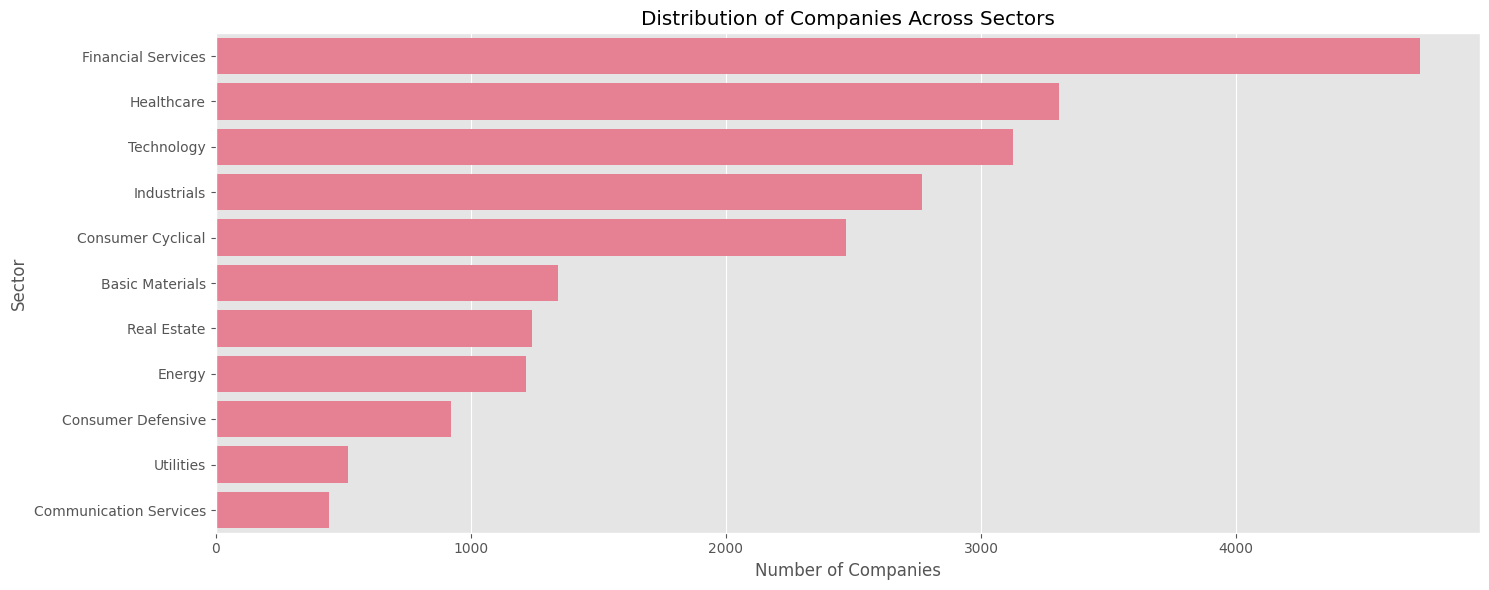

<Figure size 1000x600 with 0 Axes>

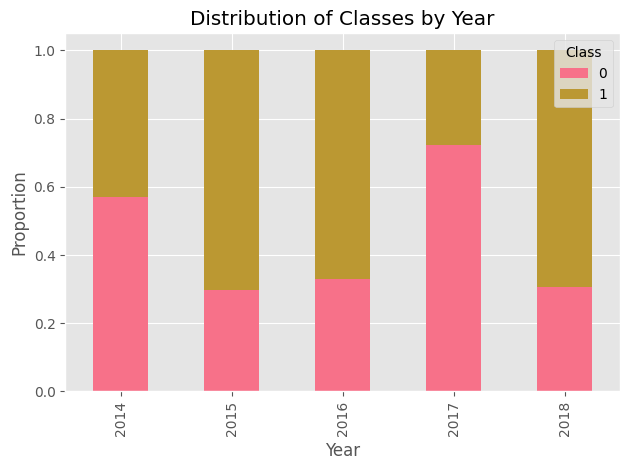

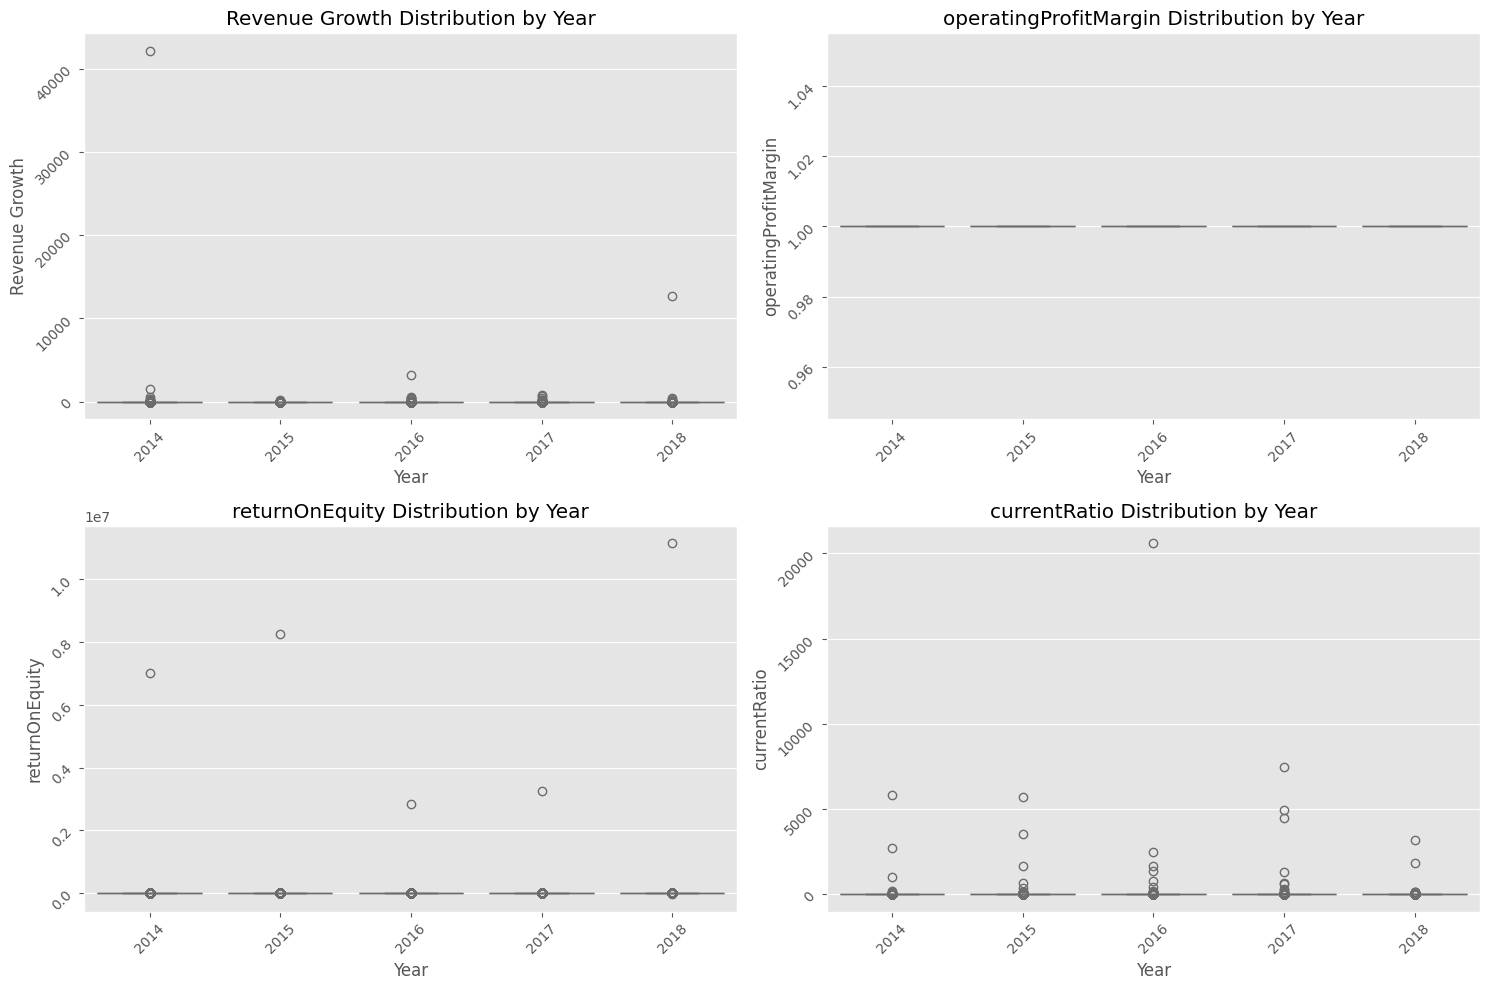

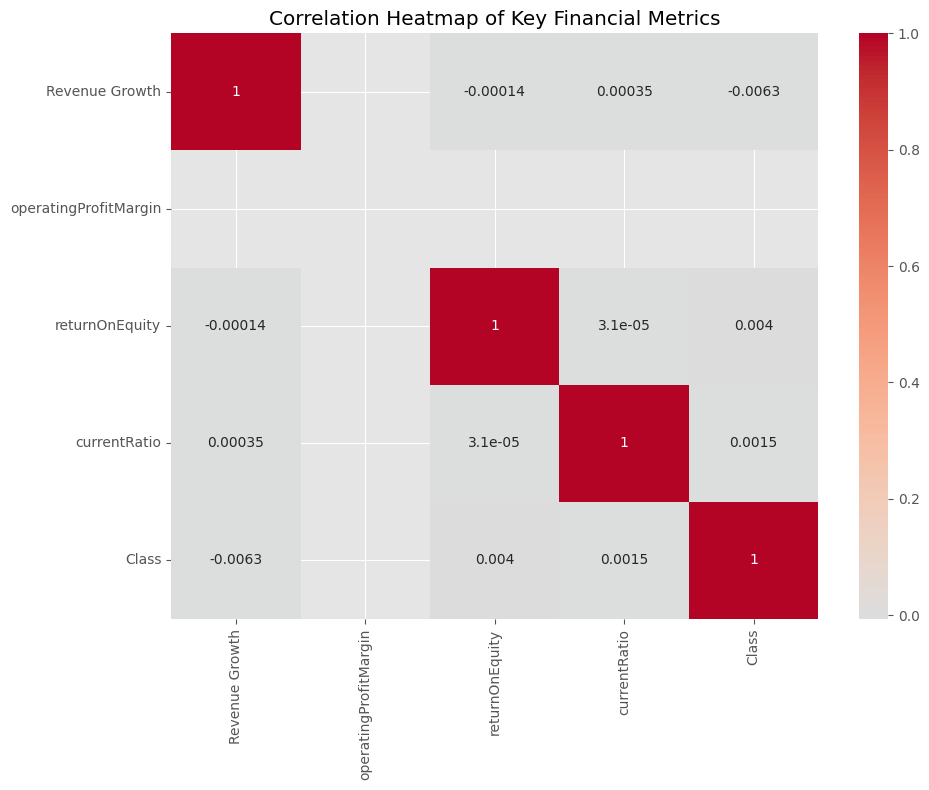

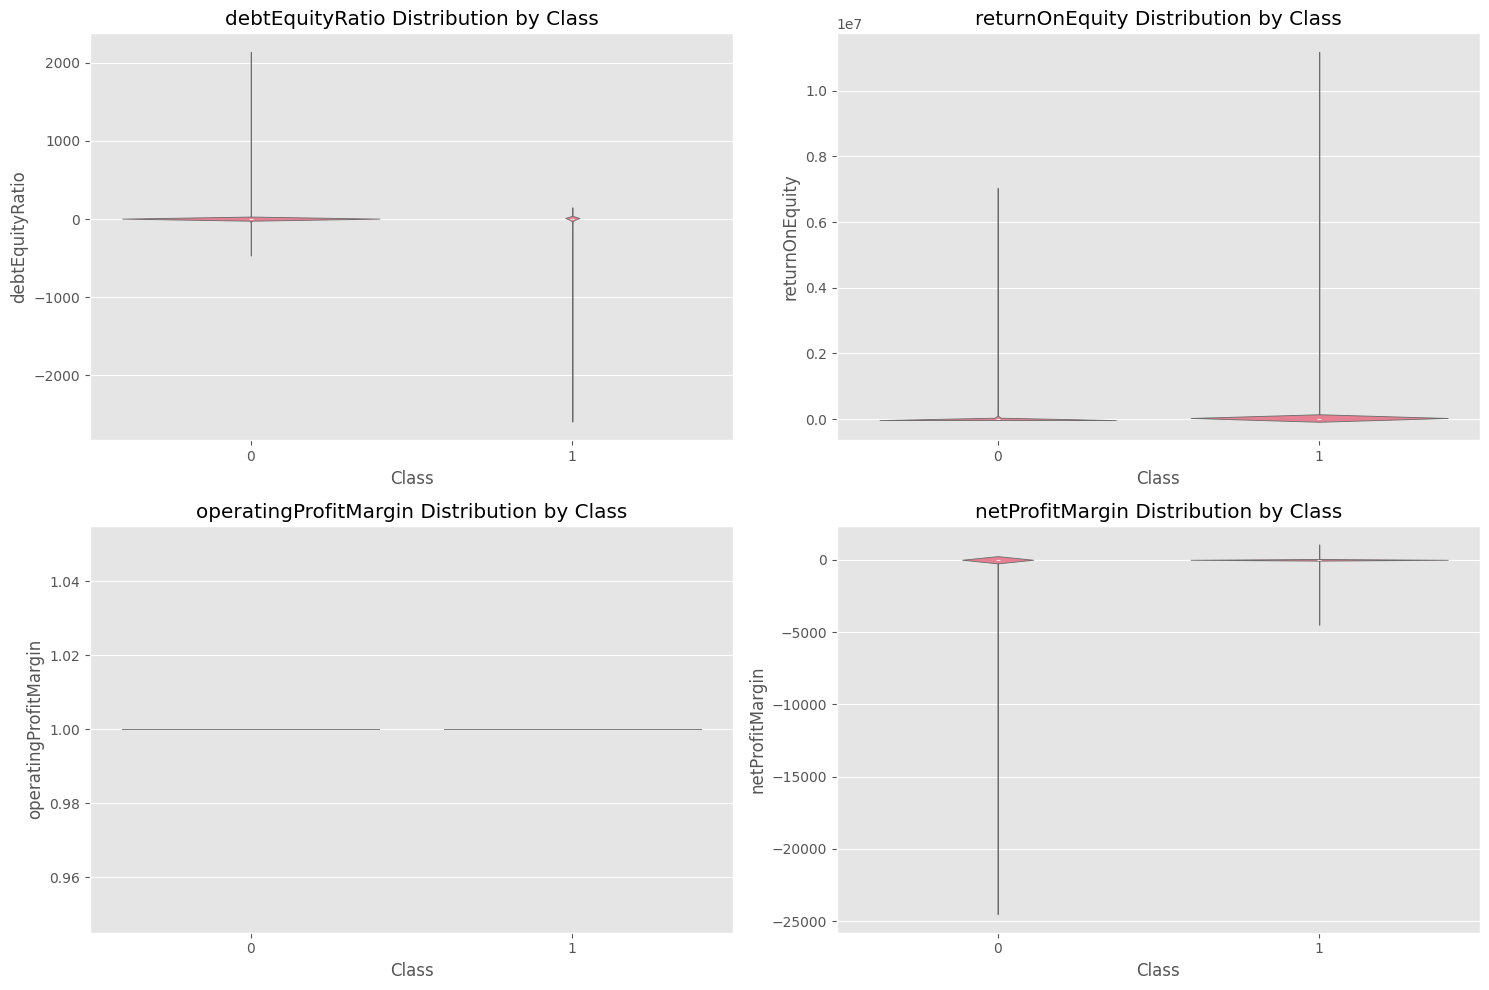

/var/folders/c1/53z973695gq_455l_pxlpknm0000gn/T/ipykernel_42809/1172903918.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Interest_Coverage'] = df['EBIT'] / df['Interest Expense']
/var/folders/c1/53z973695gq_455l_pxlpknm0000gn/T/ipykernel_42809/1172903918.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Asset_Turnover'] = df['Revenue'] / df['Total assets']


Successfully added financial ratios
Applied log transformation to Market Cap
Applied log transformation to Total assets


KeyboardInterrupt: 

In [4]:
if __name__ == "__main__":
    # Step 1: Load Data
    data_frames, combined_df = load_financial_data()
    
    # Step 2: Initial Analysis
    missing_info = analyze_data_quality(combined_df)
    plot_data_distribution(combined_df)
    analyze_key_metrics(combined_df)
    analyze_financial_ratios(combined_df)
    
    # Step 3: Preprocess Data
    processed_df, scaler, selected_features = preprocess_data(combined_df)
    
    # Analyze feature importance
    importance_df = analyze_feature_importance(
        processed_df.drop('Class', axis=1), 
        processed_df['Class'],
        processed_df.drop('Class', axis=1).columns
    )

    print("Shape of processed dataset:", processed_df.shape)
    print("\nTop 10 most important features:")
    print(importance_df.head(10))